In [19]:
import csv
import numpy as np
from os import listdir
import matplotlib
import matplotlib.pyplot as plt
import scipy
import json
import copy
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ptitprince as pt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)


In [20]:
action_id =["att","mvc","mva","mvt","congrats","encour","rul"]

with open('sup_event.csv') as f:
    l=[]
    r = csv.reader(f, delimiter=";")
    for row in r:
        l.append(row)
    sup_event=[]
    for r_num,row in enumerate(l):
        for i in range(25):
            for j in range(4):
                c=[row[2*(4*i+j)],row[2*(4*i+j)+1]]
                if r_num==0:
                    if j==0:
                        sup_event.append([[c]])
                    else:
                        sup_event[i].append([c])
                else:
                    if c != ["",""]:
                        sup_event[i][j].append(c)
    
with open('aut_event.csv') as f:
    l=[]
    r = csv.reader(f, delimiter=";")
    for row in r:
        l.append(row)
    aut_event=[]
    count=0
    for r_num,row in enumerate(l):
        for i in range(25):
            for j in range(4):
                c=[row[2*(4*i+j)],row[2*(4*i+j)+1]]
                if c[1]=="congrats":
                    count+=1
                if r_num==0:
                    if j==0:
                        aut_event.append([[c]])
                    else:
                        aut_event[i].append([c])
                else:
                    if c != ["",""]:
                        aut_event[i][j].append(c)

In [21]:
sup_actions=[]
for child in sup_event:
    actions=np.zeros(len(action_id))
    for interaction in child:
        for event in interaction:
            try:
                actions[action_id.index(event[1].split("_")[0])]+=1
            except:
                pass
    sup_actions.append(actions)
aut_actions=[]
for child in aut_event:
    actions=np.zeros(len(action_id))
    for interaction in child:
        for event in interaction:
            try:
                actions[action_id.index(event[1].split("_")[0])]+=1
            except:
                pass
    aut_actions.append(actions)
sup_actions=np.transpose(sup_actions)
aut_actions=np.transpose(aut_actions)

In [73]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}
saving = True
def get_time_between(data, ev1, ev2):    
    t=0
    ts=[]
    for c in data:
        for r in c:
            t=None
            for event in r:
                if event[1].startswith(ev2) and t is not None:
                    ts.append(float(event[0])-float(t))    
                if event[1].startswith(ev1):
                    t=event[0]
    return ts

def get_frame_time(event_list):
    d_e={"type":[],"time":[],"condition":[]}
    for i in event_list:
        t1=get_time_between(sup_event,i[0],i[1])
        t2=get_time_between(aut_event,i[0],i[1])

        for t in t1:
            d_e["type"].append(i[0]+"_"+i[1])
            d_e["time"].append(t)
            d_e["condition"].append("Supervised")
        for t in t2:
            d_e["type"].append(i[0]+"_"+i[1])
            d_e["time"].append(t)
            d_e["condition"].append("Autonomous")

    return pd.DataFrame(d_e)
def raincloud_plot(data, x, hue, y, offset_box, offset_violin, x_tick_labels, y_label,max_y,name=None):
    palette=[sns.color_palette('bright')[1],sns.color_palette('muted')[0]]
    f, (ax) = plt.subplots(1, 1,figsize=(20,7))
    local_font=copy.copy(font)
    local_font["size"]+=1

    sns.stripplot(x=x, y=y, hue=hue, data=data,dodge=True,palette=palette, jitter=True,zorder=-1)
    bplot=sns.boxplot(x=x, y=y, hue=hue, data=data,dodge=True,palette=palette,linewidth=3,
                      width=.24,whis=1.5,zorder=5,boxprops={'facecolor':'None'}, fliersize=0)
    
    t = matplotlib.transforms.Affine2D().translate(offset_box,0)
    for i in range(len(x_tick_labels)):
        bplot.artists[2*i].set_transform(bplot.artists[2*i].get_transform() - t)
        bplot.artists[2*i+1].set_transform(bplot.artists[2*i+1].get_transform() + t)
        n=6
        for j in range(n):
            bplot.lines[2*i*n+j].set_transform(bplot.lines[2*i*n+j].get_transform() - t)
            bplot.lines[(2*i+1)*n+j].set_transform(bplot.lines[(2*i+1)*n+j].get_transform() + t)
    pt.half_violinplot(x=x, y=y, data=data, hue=hue, palette=palette, cut = 2, bw=.5,
                      scale="area", width=.8, inner = None, orient="v", offset=offset_violin)
    
    handles, labels = ax.get_legend_handles_labels()
    l = ax.legend(handles[0:2], labels[0:2], loc='upper left',prop={'size': local_font["size"]})
    
    locs, labels = plt.xticks()
    plt.xticks(locs, x_tick_labels, rotation=0,**local_font)
    plt.xlabel("", **local_font)
    local_font["size"]+=3
    plt.ylabel(y_label, **local_font)
    plt.ylim([-1,max_y])
    plt.show()
    if name:
        f.savefig(name,bbox_inches="tight")

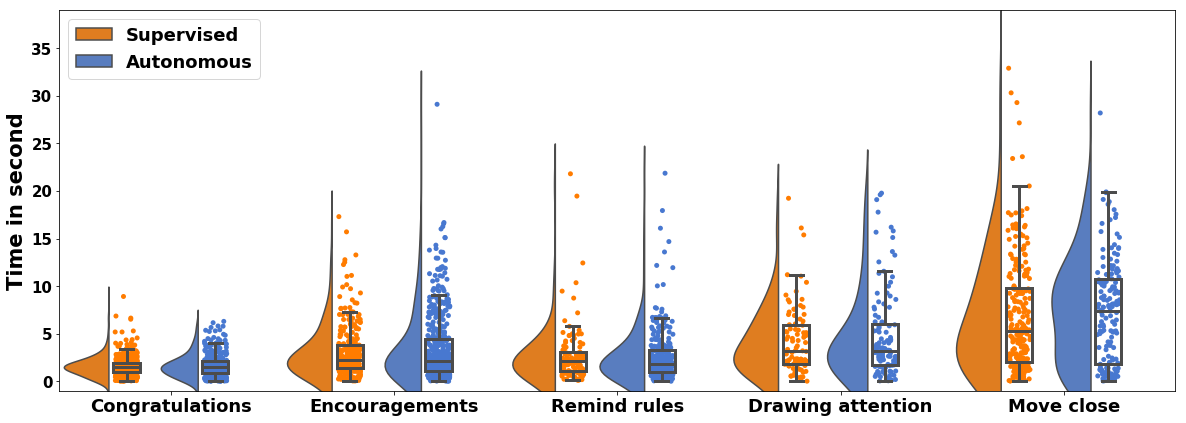

In [75]:
events=["animaleat"]
actions=["cong","enc","rul","att","mvc"]
data=get_frame_time([["animaleat",a] for a in actions])

x="type"; hue="condition"; y="time"; offset_box=31
x_tick_labels=[ "Congratulations", "Encouragements","Remind rules", "Drawing attention","Move close"]
y_label = "Time in second"
name="./figs/timing_actions_animal_eat.pdf"
max_y=39;offset_violin=0.08
raincloud_plot(data, x, hue, y, offset_box, offset_violin, x_tick_labels, y_label, max_y,name)

In [ ]:
action_labels = ["Draw Attention", "Move close", "Move away","Move to", "Congratulation","Encouragements","Remind rules"]

def plot_action(actions,name,saving=True,first=False):
    if first:
        f, ax1 = plt.subplots(figsize=(15,3))
    else:
        f, ax1 = plt.subplots(figsize=(15,3))
    cax=ax1.matshow(actions, cmap='jet', vmin=0,vmax=30)
    plt.yticks(np.arange(len(action_labels)), action_labels)
    
    plt.gca().xaxis.tick_bottom()
    if first:
        plt.xlabel("Individual Children",**font)
        ax1.xaxis.set_label_position('top')
    plt.xticks(range(25), ["" for i in range(25)]) 
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="3%", pad=0.1)
    cbar=f.colorbar(cax, cax=cax1)
    cbar.set_ticks([0,10,20])
    cbar.ax.set_yticklabels([0, 10,20]) 
    plt.show()
    if saving:
        f.savefig("./figs/"+name+"_actions.pdf",bbox_inches="tight")
plot_action(sup_actions,"supervised",saving=True,first=True)
plot_action(aut_actions,"autonomous",saving=True,first=False)

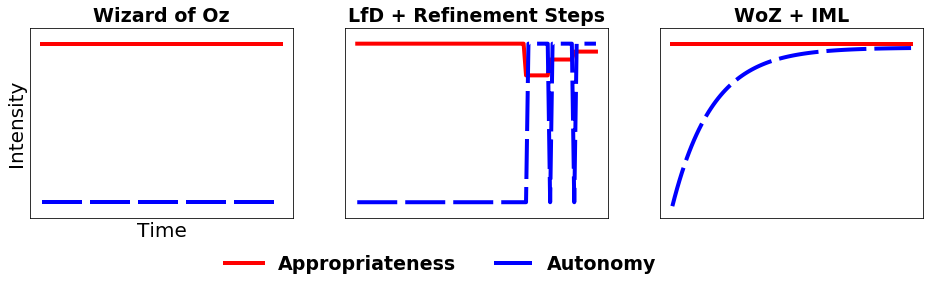

In [20]:
saving=True
weight='bold'
fontsize=19
x=np.arange(100)
lfd=np.zeros((len(x),2))
wz=np.zeros((len(x),2))
sp=np.zeros((len(x),2))
for i in x:
    wz[i][0]=1
    wz[i][1]=0.
    
    if i<len(x)*.7:
        lfd[i][0]=1
        lfd[i][1]=0
    elif i<len(x)*.8:
        lfd[i][0]=0.8
        lfd[i][1]=1
    elif i<len(x)*.9:
        lfd[i][0]=0.9
        lfd[i][1]=1
    else:
        lfd[i][0]=0.95
        lfd[i][1]=1

    sp[i][0]=1
    sp[i][1]=.975-np.exp(-i*6./len(x))
lfd[int(len(x)*.7)][1]=0
lfd[int(len(x)*.8)][1]=0
lfd[int(len(x)*.9)][1]=0

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_size_inches(16,3.5)
linewidth=4
dashes=[[10,2]]
color=['r','b']
ax1.plot(wz[:,0],color[0],linewidth=linewidth)
ax2.plot(lfd[:,0],color[0],linewidth=linewidth)
ax3.plot(sp[:,0],color[0],linewidth=linewidth)
ax1.plot(wz[:,1],color[1],linewidth=linewidth,dashes=dashes[0])
ax2.plot(lfd[:,1],color[1],linewidth=linewidth,dashes=dashes[0])
ax3.plot(sp[:,1],color[1],linewidth=linewidth,dashes=dashes[0])

ax1.set_title("Wizard of Oz",fontsize=fontsize, fontweight=weight)
ax2.set_title("LfD + Refinement Steps",fontsize=fontsize, fontweight=weight)
ax3.set_title("WoZ + IML",fontsize=fontsize, fontweight=weight)
#ax3.set_title("SPARC",fontsize=fontsize, fontweight=weight)
for ax in [ax1,ax2,ax3]:
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',         # ticks along the top edge are off
        right='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off') # labels along the bottom edge are off
plt.ylim(-.1,1.1)

legend_properties = {'weight':weight,"size":fontsize}
ax1.set_ylabel('Intensity', fontsize=fontsize+1)
ax1.set_xlabel('Time', fontsize=fontsize+1)

plt.legend(labels=["Appropriateness","Autonomy"], bbox_to_anchor=(.05,-0.1), prop=legend_properties,ncol=4,frameon=False)
#plt.savefig("concept.pdf",bbox_inches='tight')
if saving:
    plt.savefig("./figs/concept.pdf",bbox_inches='tight')
plt.show()